## Linear Regression Model

In [3]:
class LinearRegressionUsingGD:
    """Linear Regression Using Gradient Descent.
    Parameters
    ----------
    eta : float
        Learning rate
    n_iterations : int
        No of passes over the training set
    Attributes
    ----------
    w_ : weights/ after fitting the model
    bias_ : bias / after fitting the model
    cost_ : total error of the model after each iteration
    """

    def __init__(self, eta=0.05, n_iterations=100):
        self.eta = eta
        self.n_iterations = n_iterations

    def fit(self, x, y):
        """Fit the training data
        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
            Training samples
        y : array-like, shape = [n_samples, n_target_values]
            Target values
        Returns
        -------
        self : object
        """

        self.cost_ = []
        self.w_ = np.zeros((x.shape[1], 1))
        self.bias_ = np.zeros((1,1))
#         self.bias_ = np.zeros((x.shape[1], 1))
        '''m is trainning data set'''
        m = x.shape[0]
        for _ in range(self.n_iterations):
            y_pred = np.dot(x, self.w_) + self.bias_
            residuals = y_pred - y
            gradient_vector_weight = np.dot(x.T, residuals)
            gradient_vector_bias = np.sum(residuals) 
            self.w_ = self.w_ - (self.eta / m) * gradient_vector_weight
            self.bias_ = self.bias_ - (self.eta / m) * gradient_vector_bias
            cost = np.sum((residuals ** 2)) / (2 * m)
            self.cost_.append(cost)
        #print("this is cost")
        #print(self.cost_)
        return self

    def predict(self, x):
        """ Predicts the value after the model has been trained.
        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
            Test samples
        Returns
        -------
        Predicted value
        """
        return np.dot(x, self.w_) + self.bias_

In [4]:
#import 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import linear_model
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import sys
np.set_printoptions(threshold=500)


## Input data

In [5]:
#get data from each file
train_data = pd.read_csv('Teleplay.csv', sep=',')
predict_data = pd.read_csv('New_Teleplay.csv', sep=',')
rating_data = pd.read_csv('Rating.csv', sep=',')

#this data is used for inserting the rating into the New_Teleplay.csv at the end.
New_Teleplay = pd.read_csv('New_Teleplay.csv', sep=',')
New_Teleplay.drop(['rating'], axis=1,inplace=True)


## Map and Reduce function to get the average rating from Rating.csv

In [6]:
#map and reduce functions to get the average rating from Rating.csv
def mapping(ratings):
    unique=set()
    ratings_dict = {} 
    for line in ratings.itertuples(): 
            tid=line.teleplay_id
            if tid not in unique:
                unique.add(tid) 
                ratings_dict[tid] = [line.rating]
            else:
                #ratings_dict[tid].append(line.rating)
                if (line.rating > 0):
                    ratings_dict[tid].append(line.rating)
    return ratings_dict

rating_of_each_movie_ratingcsv = mapping(rating_data)

def reducing(ratings_dict):
    avg_rating_dict={}
    for key,value in ratings_dict.items():
        avg_rating_dict[key] = round(sum(value)/len(value),2)
    return avg_rating_dict

    
rating_of_each_movie_ratingcsv = reducing(rating_of_each_movie_ratingcsv)

## Attach the average rating as new feature to teleplay

In [7]:
#insert the avg rating from Rating.csv to train_data
train_data['avg_rating_from_ratingcsv'] = train_data['teleplay_id'].map(rating_of_each_movie_ratingcsv)
predict_data['avg_rating_from_ratingcsv'] = predict_data['teleplay_id'].map(rating_of_each_movie_ratingcsv)

# Data preprocessing

## Data filtration to select suitable features

In [8]:
#select suitable features
train_data.drop(['teleplay_id', 'name'], axis=1,inplace=True)
predict_data.drop(['teleplay_id', 'name','rating'], axis=1,inplace=True)

#delete null data for train data
train_data = train_data.dropna(how='any',axis=0)
train_data = train_data.reset_index(drop=True)

## Feature encoding 

In [9]:
#feature encoding for training data
for line in range(0,train_data.shape[0]):
    if(train_data.iloc[line].episodes == 'Unknown'):
        train_data.at[line, 'episodes'] = 0
    if (train_data.iloc[line].type == 'short'):
        train_data.at[line, 'type'] = 1
    elif (train_data.iloc[line].type == 'medium'):
        train_data.at[line, 'type'] = 2
    elif (train_data.iloc[line].type == 'long'):
        train_data.at[line, 'type'] = 3
    elif (train_data.iloc[line].type == 'Special'):
        train_data.at[line, 'type'] = 4
    elif (train_data.iloc[line].type == 'ONA'):
        train_data.at[line, 'type'] = 5
    else:
        train_data.at[line, 'type'] = 0
    
        
#feature encoding for predicted data
for line in range(0,predict_data.shape[0]):
    if(predict_data.iloc[line].episodes == 'Unknown'):
        predict_data.at[line, 'episodes'] = 0
    if (predict_data.iloc[line].type == 'short'):
        predict_data.at[line, 'type'] = 1
    elif (predict_data.iloc[line].type == 'medium'):
        predict_data.at[line, 'type'] = 2
    elif (predict_data.iloc[line].type == 'long'):
        predict_data.at[line, 'type'] = 3
    elif (predict_data.iloc[line].type == 'Special'):
        predict_data.at[line, 'type'] = 4
    elif (predict_data.iloc[line].type == 'ONA'):
        predict_data.at[line, 'type'] = 5
    else:
        predict_data.at[line, 'type'] = 0

#change string value or object to integer
train_data['episodes'] = train_data['episodes'].astype(int)
train_data['type'] = train_data['type'].astype(int)
predict_data['episodes'] = predict_data['episodes'].astype(int)
predict_data['type'] = predict_data['type'].astype(int)

train_data.head()

,genre,type,episodes,rating,members,avg_rating_from_ratingcsv
0,"Drama, Romance, School, Supernatural",3,1,9.37,200630,9.43
1,"Action, Comedy, Historical, Parody, Samurai, S...",2,51,9.25,114262,9.44
2,"Sci-Fi, Thriller",2,24,9.17,673572,9.26
3,"Action, Comedy, Historical, Parody, Samurai, S...",2,51,9.16,151266,9.27
4,"Comedy, Drama, School, Shounen, Sports",2,10,9.15,93351,9.17


## Fill null data for predicted data

In [10]:
#fill the null data of train data for each feature

train_data["avg_rating_from_ratingcsv"] = train_data["avg_rating_from_ratingcsv"].fillna(train_data["avg_rating_from_ratingcsv"].mean())
train_data['avg_rating_from_ratingcsv'] = train_data['avg_rating_from_ratingcsv'].astype(float)

#fill the null data of predict data for each feature
predict_data["episodes"] = predict_data["episodes"].fillna(predict_data["episodes"].mean())
predict_data["type"] = predict_data["type"].fillna(predict_data["type"].mode()[0])
predict_data["genre"]=predict_data["genre"].fillna(predict_data["genre"].mode()[0])
predict_data["avg_rating_from_ratingcsv"] = predict_data["avg_rating_from_ratingcsv"].fillna(predict_data["avg_rating_from_ratingcsv"].mean())
predict_data['avg_rating_from_ratingcsv'] = predict_data['avg_rating_from_ratingcsv'].astype(float)
print(train_data.isnull().sum())
print(predict_data.isnull().sum())

genre                        0
type                         0
episodes                     0
rating                       0
members                      0
avg_rating_from_ratingcsv    0
dtype: int64
genre                        0
type                         0
episodes                     0
members                      0
avg_rating_from_ratingcsv    0
dtype: int64


## Feature  scaling

In [11]:
#data smoothing
train_data["members"]=train_data["members"].apply(np.log1p)
predict_data["members"]=predict_data["members"].apply(np.log1p)
train_data["episodes"]=train_data["episodes"].apply(np.log1p)
predict_data["episodes"]=predict_data["episodes"].apply(np.log1p)

## One-hot encoding for genres

In [12]:
#find out how many genres
genres = []
for line in train_data.itertuples(index=False):
    for genre in line.genre.split(","):
        if genre.strip() not in genres:
            genres.append(genre.strip())

#one hot encoding for genres
train_data[genres] = 0
predict_data[genres] = 0
for line in range(0,train_data.shape[0]):
    for each_genre in train_data.iloc[line].genre.split(","):
        temp = each_genre.strip()
        train_data.at[line, temp] = 1

for line in range(0,predict_data.shape[0]):
    for each_genre in predict_data.iloc[line].genre.split(","):
        temp = each_genre.strip()
        predict_data.at[line, temp] = 1
        
train_data.drop(['genre'], axis=1,inplace=True)
predict_data.drop(['genre'], axis=1,inplace=True)
train_data.head()

,type,episodes,rating,members,avg_rating_from_ratingcsv,Drama,Romance,School,Supernatural,Action,...,Ecchi,Martial Arts,Dementia,Harem,Cars,Kids,Shoujo Ai,Restricted,Yaoi,Yuri
0,3,0.693147,9.37,12.209223,9.43,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,3.951244,9.25,11.646258,9.44,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,3.218876,9.17,13.420352,9.26,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,3.951244,9.16,11.926802,9.27,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2,2.397895,9.15,11.444133,9.17,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Analytics

## Prepare train data and test data

In [13]:
#convert data to np.array
y=train_data["rating"].to_numpy()
y = y.reshape(y.shape[0],1)
x=train_data.drop("rating", axis=1).to_numpy()
predict_x = predict_data.to_numpy()

#set up training data and test data
train_x, test_x, train_y, test_y=train_test_split(x, y, test_size=0.33, random_state=109)
predict_rating=[]

   ## Run linear regression model and input data to New_Teleplay.csv

Mean squared error: 0.42
Coefficient of determination: 0.56


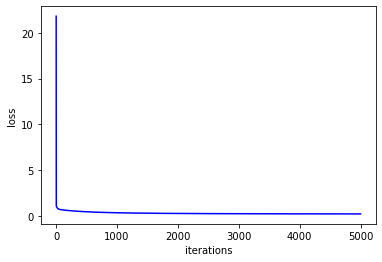

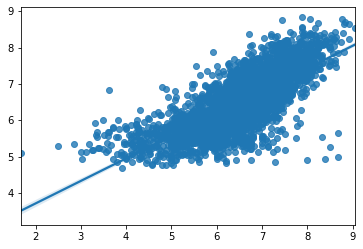

In [14]:
def run():
    #model Initialization
    model = LinearRegressionUsingGD(eta=0.01,n_iterations=5000)
    model.fit(train_x,train_y)
    y_pred = model.predict(test_x)
    
    #use model to predict the rating for New_Teleplay.csv
    predict_rating = model.predict(predict_x)
#     print(predict_rating)
#     predict_rating = np.array(predict_rating, dtype=np.float)
    #round predicted rating to 2 decimal places
    round_predict_rating = np.around(predict_rating, decimals=2)
    
    #store the predicted rating to New_Teleplay.csv
    New_Teleplay['rating'] = round_predict_rating.reshape((round_predict_rating.shape[0]))
    New_Teleplay.to_csv('18063466D_task1.csv',index=False)
    
    #model evaluation
    
    # The mean squared error
    print('Mean squared error: %.2f'% mean_squared_error(test_y, y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'% r2_score(test_y, y_pred))
    plt.ylabel("loss")
    plt.xlabel("iterations")
    plt.plot(model.cost_, color = 'b')
    plt.show()

    sns.regplot(x=test_y, y=y_pred)
run()

# Neural Network for telepaly data

[[ 1.          0.69314718  4.06044301 ...  0.          0.
   0.        ]
 [ 2.          2.56494936 13.33433597 ...  0.          0.
   0.        ]
 [ 3.          0.69314718  6.79346613 ...  0.          0.
   0.        ]
 ...
 [ 2.          4.35670883 11.52315299 ...  0.          0.
   0.        ]
 [ 5.          1.38629436  4.65396035 ...  0.          0.
   0.        ]
 [ 3.          0.69314718  6.16541785 ...  0.          0.
   0.        ]]
[[5.71]
 [8.07]
 [6.89]
 ...
 [8.36]
 [4.53]
 [6.81]]


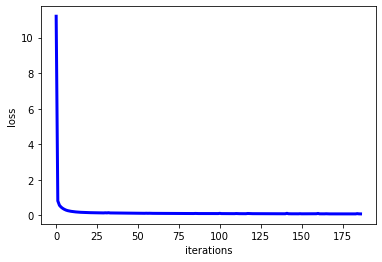

Accuracy: 0.7539170884731553


In [15]:
#import for neural network
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
print(train_x)
print(train_y)
clf = MLPRegressor(random_state=109,max_iter=10000,solver="adam",learning_rate="constant")
clf.fit(train_x,np.ravel(train_y))

plt.plot(clf.loss_curve_, color='blue', linewidth=3)
plt.ylabel("loss")
plt.xlabel("iterations")
plt.show()

accuracy = clf.score(test_x,test_y)
print("Accuracy:",accuracy)
